In [1]:
# You don't have to reload on each library update
%load_ext autoreload
%autoreload 2
%matplotlib inline

import tensorflow as tf

from methods import *
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, add
from tensorflow.keras.layers import Layer, Dense, Dropout, Activation, Flatten, Reshape, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from tensorflow.keras.regularizers import l2

from tensorflow.python.client import device_lib

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print(gpus)
    except RuntimeError as e:
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
augmented_imgs_path = 'D:/20.share/jaehochang/SP2Robotics/videos/'
args = {'IMAGES': []} 
for root, dirs, files in os.walk(augmented_imgs_path):
    for file in files:
        args['IMAGES'].append(os.path.join(root, file))

augmenters_c = {
    'Env':{
#         'Snowy': ia.FastSnowyLandscape(lightness_threshold=150, lightness_multiplier=2.5),
#         'Clouds': ia.Clouds(),
#         'Fog': ia.Fog(),
#         'Snowflakes': ia.Snowflakes(flake_size=(0.1, 0.4), speed=(0.01, 0.05)),
#         'Rain': ia.Rain(drop_size=(0.10, 0.20), speed=(0.1, 0.3)),
#         'Darken': ia.Multiply(.3, per_channel=.5)
    },
    'Trs':{
        'GN': ia.AdditiveGaussianNoise(loc=0, scale=(0.0, 1/10*255), per_channel=0.2),
#         'VertFlip': ia.Flipud(),
#         'HorizFlip': ia.HorizontalFlip(),
#         'Rotate': ia.Rotate(rotate=(-45, 45)),
#         'Zoom': ia.Affine(scale={"x": (1, 1.5), "y": (1, 1.5)})
    }
}

index = 1
frames = []
aimgs = []

factor = 10
h, w = 9 * 4 * factor, 16 * 4 * factor
resizer = ia.size.Resize({"height": h, "width": w})
gray_scaler = ia.Grayscale()
print(resizer)

try:
    pbar.close()
except:
    1
    
with tf.device('/device:GPU:0'):
    for IMAGE in args['IMAGES'][:1]:
        for _, augmenters in augmenters_c.items():
            for augmenter_name, augmenter in augmenters.items():
                cap = cv2.VideoCapture(IMAGE)
                fourcc = cv2.VideoWriter_fourcc(*'MJPG')
                noisy_out = cv2.VideoWriter(f"{augmenter_name}_{IMAGE.split('/')[-1].split('.')[0]}.avi", fourcc, 5, (w, h))
                clean_out = cv2.VideoWriter(f"{IMAGE.split('/')[-1].split('.')[0]}.avi", fourcc, 5, (w, h))
                ret, frame = cap.read()
                d, k = 1, 8000
                pbar = tqdm(total = d * k)
                while ret and index < d*k:
                    if index % d == 0:
                        frame = resizer.augment_image(frame)
                        frame = gray_scaler.augment_image(frame)
                        frames.append(frame)
                        clean_out.write(frame)
                        
                        aimg = aug_img(frame, augmenter)
                        aimgs.append(aimg)
                        noisy_out.write(aimg)
                        
                        pbar.update(d)
                    index += 1
                    ret, frame = cap.read()
                index = 1
                pbar.close()

cap.release()
clean_out.release()
noisy_out.release()
cv2.destroyAllWindows()

Resize(name=UnnamedResize, parameters=[(Deterministic(int 360), Deterministic(int 640)), Deterministic(cubic), HW], deterministic=False)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 7999/8000 [06:37<00:00, 20.12it/s]


In [4]:
fa = np.asarray([*zip(frames, aimgs)])
fa.shape

(7999, 2, 360, 640, 3)

### Noisy vs. Clean train image

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x1f2c495f970>)

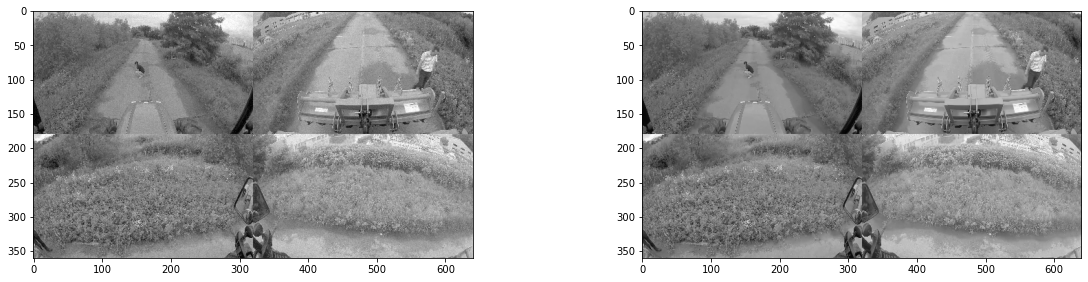

In [5]:
from sklearn import model_selection
X_trains, X_tests = [], []

X_train, X_test = model_selection.train_test_split(fa, test_size = 0.2)
X_train, X_test = np.asarray(X_train), np.asarray(X_test)

X_train = X_train.astype("float32")/255.
X_test = X_test.astype("float32")/255.

plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 2), plt.imshow(X_train[212][0])
plt.subplot(2, 2, 1), plt.imshow(X_train[212][1])
# plt.subplot(2, 2, 4), plt.imshow(X_train[502][0])  # train (output)
# plt.subplot(2, 2, 3), plt.imshow(X_train[502][1])  # noisy train (input)

In [6]:
X_train.shape, X_test.shape

((6399, 2, 360, 640, 3), (1600, 2, 360, 640, 3))

## 2. Denoising autoencoder

### Create the network

In [7]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
with tf.device('/GPU:0'):
    x = keras.layers.Input(shape=X_train[0,0].shape)
    
    # Encoder
    conv1_1 = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    conv1_1 = BatchNormalization()(conv1_1)
    pool1 = MaxPooling2D((2, 2), padding='same')(conv1_1)
    pool1 = BatchNormalization()(pool1)
    conv1_2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv1_2 = BatchNormalization()(conv1_2)
    h = MaxPooling2D((2, 2), padding='same')(conv1_2)
    h = BatchNormalization()(h)

    # Decoder
    conv2_1 = Conv2D(64, (3, 3), activation='relu', padding='same')(h)
    conv2_1 = BatchNormalization()(conv2_1)
    up1 = UpSampling2D((2, 2))(conv2_1)
    up1 = BatchNormalization()(up1)
    conv2_2 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
    conv2_2 = BatchNormalization()(conv2_2)
    up2 = UpSampling2D((2, 2))(conv2_2)
    up2 = BatchNormalization()(up2)
    r = Conv2D(3, (3, 3), activation='linear', padding='same')(up2)

    optmz = keras.optimizers.SGD()
    loss = keras.losses.MeanSquaredError()
    
    autoencoder = Model(inputs=x, outputs=r)
    autoencoder.compile(optmz, loss)

    epochs = 30
    batch_size = 4
    
#     print(autoencoder.summary())
    history = autoencoder.fit(X_train[:, 1], X_train[:, 0],  # noisy train, train
                              batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test[:, 1], X_test[:, 0]))
    

Epoch 1/30
 913/1600 [================>.............] - ETA: 48s - loss: 0.0979 ETA: 48

In [ ]:
decoded_imgs = autoencoder.predict(X_test[:, 1])

### Plot

In [ ]:
plt.figure(figsize=(20, 20))
for i, j in enumerate([22]):
    # display original
    ax = plt.subplot(1, 2, 1)
    plt.imshow(X_test[:, 1][j])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    # display reconstruction
    ax = plt.subplot(1, 2, 2)
    plt.imshow(decoded_imgs[j])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

### Plot the losses

In [ ]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

---

---

---